# Neighbourhood Based Collaborative Filtering

The code below calculates the neighbourhood based collaborative filtering for the item based method.  

In [72]:
import pandas as pd
import numpy as np
import random

We are first converting our data frame into a numpy matrix. This will help us to calculate the similarity matrix

In [73]:
def convert_matrix(data,user,item,rating):
    '''
    Input: 
    
        data: This consists of the Dataframe which has the user IDs, movie IDs and the ratings
        user: This is the column name for the user IDs in the Data. 
        item: This is the column name for the item ID in the Data. 
        rating: This is the column name of the rating values in the Data 
    
    Output: 
        
        matrix: This is a matrix of dimension users x items  
    '''
    matrix = data.pivot(index=user, columns=item, values=rating).as_matrix()
    return matrix   

The function *get_user_mean()* and *centralize_matrix()* allows us to calculate the user mean and then centralize the matrix

In [74]:
def get_user_mean(matrix):
    '''
    Input:
    
        matrix: This consists of the sparse users x items matrix
    
    Output:
    
        Will be a numpy array of length equal to the number of users which will consist of the user mean. 
        
    '''
    return np.nanmean(matrix, axis = 1)

In [75]:
def centralize_matrix(matrix):
    '''
    Input:
        
        matrix: This consists of the sparse users x items matrix
    
    Output:
        centered_matrix: This consists of the sparse users x items matrix centered by the user mean. 
        
    '''
    user_mean = get_user_mean(matrix)
    centered_matrix = matrix - user_mean[:, np.newaxis]
    return centered_matrix

Once we have the centralized matrix. We require to calculate the adjusted cosine similarity matrix which is given by the formula below

$$ AdjustedCosine(i, j) = \frac{\Sigma_{u\in U_i \cap U_j} s_{ui}s_{uj}}{\sqrt{\Sigma_{u\in U_i \cap U_j} s_{ui}^2}\sqrt{ \Sigma_{u\in U_i \cap U_j} s_{uj}^2}}$$

where $s_{ui} = r_{uj} − \mu_{u}$ and $U_i$ represents users who have consumed Item $i$. 

Calculating the above formula for each $(i,j)$ would take a long time to compute and would not be scalable if implemented through for loops. So we need to identify a way to vectorize the above formula

Denoting the centered matrix by $C$. We can see that the numerator of $AdjustedCosine(i, j)$ is $C^TC$ where the $nan$ entries have been replaced by $0$

When seeing the denominator, we see that the we require to calculate the sum of the squares of the elements in $C$ where column $i$ and $j$ are bot not missing. Denote a new matrix $N$ where $N(i,j) = 1$ if $C(i,j)$ is nan else 0

Then $1 - N$ identifies all the non nan entries in C and replaces the nan entries by 0. We introduce the matrix $N$ here and do not replace the nan directly by $0$ since ratings equal to the mean would be equated to nan which is not a correct implementation

Denoting $C^2$ as the element wise squares of the matrix $C$. 
$$ X = C^2 * (1-N)$$

Then $$X(i,j) = \Sigma_{u\in U_i \cap U_j} s_{ui}^2$$

$\sqrt{X^TX}$ calculates the value of the denominator.  The elementwise division of $C^TC$ and $\sqrt{X^TX}$ provides the adjusted cosine matrix

This is what is implemented in the function **cosine_matrix** below

In [76]:
def cosine_matrix(matrix):
    '''
    Input:
        
        matrix: The centered ratings matrix
        
    Output:
        
        output: This is the adjusted cosine matrix between items calculated based on the steps explained above
        
    '''
    where_are_NaNs = np.isnan(matrix)
    new_matrix = np.copy(matrix)
    new_matrix[where_are_NaNs] = 0
    squares = np.square(new_matrix)
    num = new_matrix.T.dot(new_matrix)
    one_matrix = np.copy(matrix)
    one_matrix[~np.isnan(one_matrix)] = 0
    one_matrix[np.isnan(one_matrix)] = 1
    one_matrix = 1 - one_matrix
    temp_matrix = squares.T.dot(one_matrix)
    den_matrix = temp_matrix.T * temp_matrix
    den = np.sqrt(den_matrix)
    output = np.divide(num,den)
    return output

Once we have the cosine matrix, we require to identify the $k$ items most similar to a given item $i$. The function *get_nearest_neighbors* calculates that using function of numpy. 

*argsort* provides the index of the sorted matrix. We use that to identify the nearest items

In [77]:
def get_nearest_neighbors(matrix, k):
    '''
    Input:
        
        matrix: The cosine matrix 
        k: The number of nearest neighbours required
    
    Output:
        
        A matrix of dimensions items x k which consists of the k nearest items for each item. 
        
    '''
    temp_matrix = np.copy(matrix)
    temp_matrix[np.isnan(temp_matrix)] = 0
    t = np.argsort(-1 * temp_matrix)
    return(t[:,1:1+k])

Once we have the nearest neighbours, we can use that to predict the ratings of a user. 

$$\hat{r_{ut}} = \frac{\Sigma_{j \in Q_t(u)}AdjustedCosine(j,t) * r_{uj}}{\Sigma_{j \in Q_t(u)}|AdjustedCosine(j, t)|}$$

The basic idea is to leverage the user’s own ratings on similar items in the final step of making the prediction

In [78]:
def predict(ratings,similarity,ranking,user,item):
    '''
    Input:
        
        ratings: The original ratings matrix
        similarity: The similarity matrix 
        ranking: The k most important items for an item 
        user: The user
        item: The item
    
    Output:
        The predicted rating for a user and item 
    
    '''
    user_ratings_for_similar_items = ratings[user-1,ranking[item-1]]
    similarity_for_similar_items = similarity[item-1,ranking[item-1]]
    value = np.dot(user_ratings_for_similar_items, similarity_for_similar_items)/sum(np.absolute(similarity_for_similar_items))
    if np.isnan(value):
        value = np.nanmean(ratings[user-1])
        value = round(value * 2) / 2
    if np.isnan(value):
        value = 3
    return value

We now split the data into different slices using the below function

In [79]:
def test_indices(matrix, split = 0.2):
    '''
    Input: 
        
        matrix: The original matrix of ratings 
        split: The percent of the data required for testing
    
    Output:
        
        train: The matrix in which (1-split)% of the non nan entries have been replaced by nan
        test_indices: Split% of the indices which have non nan values and 
    
    '''
    index = list(np.argwhere(~np.isnan(matrix)))
    test_indices = random.sample(index,int(0.2 * len(index)))
    train = np.copy(matrix)
    for idx in test_indices:
        train[idx[0],idx[1]] = np.nan
    return train,test_indices  

In [80]:
def get_error(actual,predicted):
    '''
    Input:
        
        actual: The actual ratings of the user 
        predicted: The predicted ratings of the user 
    
    Output:
        The root mean square error among the above 2 datasets 
        
    '''
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.power(np.sum((actual - predicted ) * (actual - predicted)),0.5)

Let us load the data consisting of $610$ users and $100$ movies. This is a subset of the large movielens dataset.

In [81]:
subset_data = pd.read_csv('small_subset.csv')

In [82]:
user_column_name = 'userId'
item_column_name = 'movieId'
rating_column_name = 'rating'

In [83]:
matrix = convert_matrix(subset_data, user_column_name, item_column_name, rating_column_name)

/Users/ashwin/Documents/Columbia Courses/Personalization Theory/Project/personalization_project/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


We are chossing a split size of $50:50$, $80:20$ and $90:10$. We also choose the neighbourhoods to be $1,2,3,5,10,20$

In [84]:
split_size = [0.5, 0.2, 0.1]
neighbourhood_size = [1,2,3,5,10,20]

In [86]:
error_across_split_size = []
for split in split_size:
    train,test = test_indices(matrix, split)
    centered_matrix = centralize_matrix(train)
    output = cosine_matrix(centered_matrix)
    error = []
    for k in neighbourhood_size:
        print('Split', split, ' and Neighbourhood ', k)
        nearest_items = get_nearest_neighbors(output,k)
        predicted_value = []
        actual_value = []
        for index in test:
            predicted_value += [predict(train,output,nearest_items, index[0]+1, index[1] + 1)]
            actual_value += [matrix[index[0], index[1]]]
        error += [get_error(actual_value, predicted_value)]
    error_across_split_size  += [error]

/Users/ashwin/Documents/Columbia Courses/Personalization Theory/Project/personalization_project/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/ashwin/Documents/Columbia Courses/Personalization Theory/Project/personalization_project/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


Split 0.5  and Neighbourhood  1
Split 0.5  and Neighbourhood  2
Split 0.5  and Neighbourhood  3
Split 0.5  and Neighbourhood  5
Split 0.5  and Neighbourhood  10
Split 0.5  and Neighbourhood  20
Split 0.2  and Neighbourhood  1
Split 0.2  and Neighbourhood  2
Split 0.2  and Neighbourhood  3
Split 0.2  and Neighbourhood  5
Split 0.2  and Neighbourhood  10
Split 0.2  and Neighbourhood  20
Split 0.1  and Neighbourhood  1
Split 0.1  and Neighbourhood  2
Split 0.1  and Neighbourhood  3
Split 0.1  and Neighbourhood  5
Split 0.1  and Neighbourhood  10
Split 0.1  and Neighbourhood  20


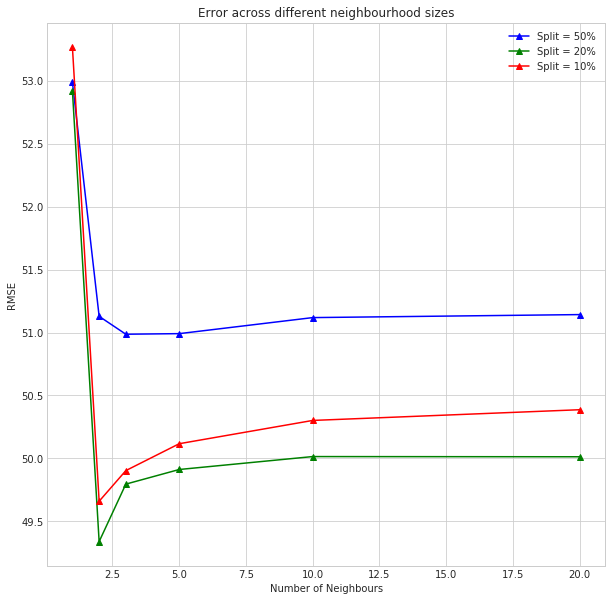

In [98]:
import matplotlib.pyplot as plt
x = neighbourhood_size
y = error_across_split_size
plt.figure(figsize=(10,10))
plt.style.use('seaborn-whitegrid')
plt.plot(x, y[0],'b^-', label='Split = 50%')
plt.plot(x, y[1],'g^-', label='Split = 20%')
plt.plot(x, y[2],'r^-', label='Split = 10%')
plt.xlabel('Number of Neighbours')
plt.ylabel('RMSE')
plt.title("Error across different neighbourhood sizes")
plt.legend()
plt.show()

Here are some interesting observations from the graph 

- When we use a single neighboour to predict the ratings, we get a really high root mean square error across the three different splits of training and testing data when the neighbourhood size is 1
- The lowest root mean square error occurs at an 80:20 train to test split. 
- The error is higher at a 90:10 split compared to the 80:20 split. This indicates an overfitting on the training data and the model does not generalize well 
- When using 100 items, a neighbourhood size of 2 gives the best results. A simple model with 2 neighbours is able to explain better than a model which has more number of neighbours